# **Imports**
---

Below are the **modules** used in the **notebook**.

In [1]:
from IPython.display import clear_output as cls
!pip install tf_explain
cls()

In [69]:
import tensorflow as tf
import cv2
import os
import sys
import random
import numpy as np
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import tifffile as tif
from PIL import Image
from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import Model

In [70]:
# Common
import os
import keras
import numpy as np
import glob
from tqdm import tqdm
import tensorflow as tf

# Data 
import tensorflow.data as tfd
import tensorflow.image as tfi
from tensorflow.keras.utils import load_img, img_to_array

# Data Visualization
import matplotlib.pyplot as plt

# Model
from keras.layers import ReLU
from keras.layers import Input
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Concatenate
from keras.layers import UpSampling2D
from keras.layers import AveragePooling2D
from keras.models import Sequential, Model
from keras.layers import BatchNormalization

# Pretrained Model
from tensorflow.keras.applications import ResNet50

# Callbacks
from keras.callbacks import Callback, ModelCheckpoint

# Model Visualization
from tensorflow.keras.utils import plot_model

# Model Explaination
from tf_explain.core.grad_cam import GradCAM

# **Data Loading**

In [71]:
def prep_image(image, crop_size, size_y, size_x):
    # Resize the image
    prepd_image = cv2.resize(image,(size_y, size_x))
    # Crop the image to remove the border black pixels
    prepd_image = prepd_image[crop_size:-crop_size, crop_size:-crop_size]
    return prepd_image

In [72]:
size_x=148
size_y=148
crop_size=10

In [73]:
################# Storing Train Images into an array #############
train_images=[]

for directory_path in glob.glob( 'C:\\Users\\IRON MAN\\Desktop\\water\\today\\app\\Water Bodies Dataset\\Images'):
    for img_path in glob.glob(os.path.join(directory_path,"*.jpg")):
        #print(img_path)
        img=cv2.imread(img_path)
        img=prep_image(img,crop_size,size_y,size_x)
        train_images.append(img)
        
train_images = np.array(train_images) #converting list to array

In [74]:
################# Storing Train Masks into an array #############
train_masks = []

for directory_path in glob.glob('C:\\Users\\IRON MAN\\Desktop\\water\\today\\app\\Water Bodies Dataset\\Masks'):
    for mask_path in glob.glob(os.path.join(directory_path,"*.jpg")):
        mask=cv2.imread(mask_path)
        mask=prep_image(mask,crop_size,size_y,size_x)
        train_masks.append(mask)
        
train_masks = np.array(train_masks) #converting list to array

In [75]:
len(train_images), len(train_masks)

(1000, 1000)

In [76]:
train_images[0].shape, train_masks[0].shape

((128, 128, 3), (128, 128, 3))

In [77]:
np.min(train_images[0]), np.max(train_images[0]), np.min(train_masks[0]), np.max(train_masks[0])

(0, 185, 0, 255)

In [78]:
#normalizing
x = train_images/255
y = train_masks/255

In [79]:
np.min(x[0]), np.max(x[0]), np.min(y[0]), np.max(y[0])

(0.0, 0.7254901960784313, 0.0, 1.0)

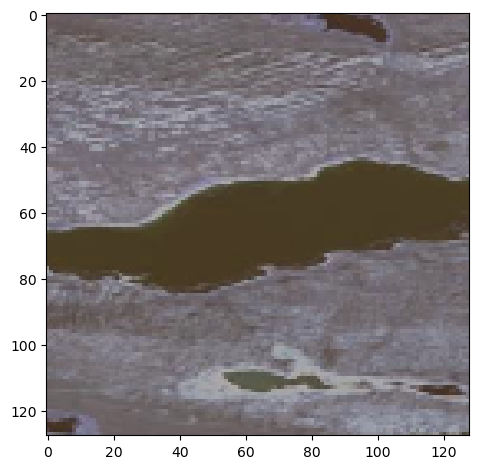

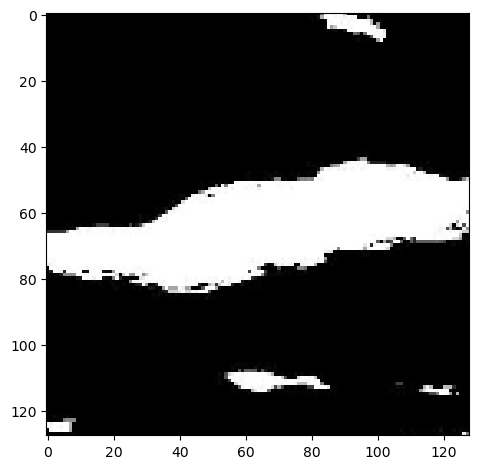

0.10980392156862745 0.7294117647058823
(128, 128, 3)
0.0 1.0
(128, 128, 3)


In [80]:
########## Displaying random image from X_train and Y_train ######### 
random_num = random.randint(0,516)
imshow(x[random_num])
plt.show()
imshow(y[random_num])
plt.show() 

test_img = x[random_num]
test_img2 = y[random_num]
print(test_img.min(), test_img.max())
print(test_img.shape)

print(test_img2.min(), test_img2.max())
print(test_img2.shape)

In [81]:
#splitting 
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# **DeepLabV3+**

**Deep Lab V3 +** extends the architecture of **Deep Lab V3** and **Deep Lab V2**. It utilises the power of **Atrous Convolution** and **Spatial Pyramid Pooling**. 

It combines the **Atrous Convolution** and **Spatial Pyramid Pooling(ASPP)** and forms the **Atrous Spatial Pyramid Pooling**. Which allows to **extract features** at **multiple scales**. Instead of using a **cascade or a parallel method**, it uses an **Encoder-Decoder architecture**. 

In which the **Encoder** learns from the **high level features** of **ResNet50** using **ASPP**, **Lower Level Features(LLF)** of **ResNet 50** are also extracted. This is because the **LLF** and the **High Level features** encodes **different information** and the **geometric information** about the object is extracted from the **LLF**, whereas the **information about the object class is extracted from the HLF**. 

These feature representations are then **concatenated** and passing through **convolutional layers for better learning**. After passing through the **Encoder- Decoder Layers** the final **Label Map is generated**.

$NOTE$ : The authors showed the **high importance** of **Batch Normalization** in performance of **DeepLabV3+**.

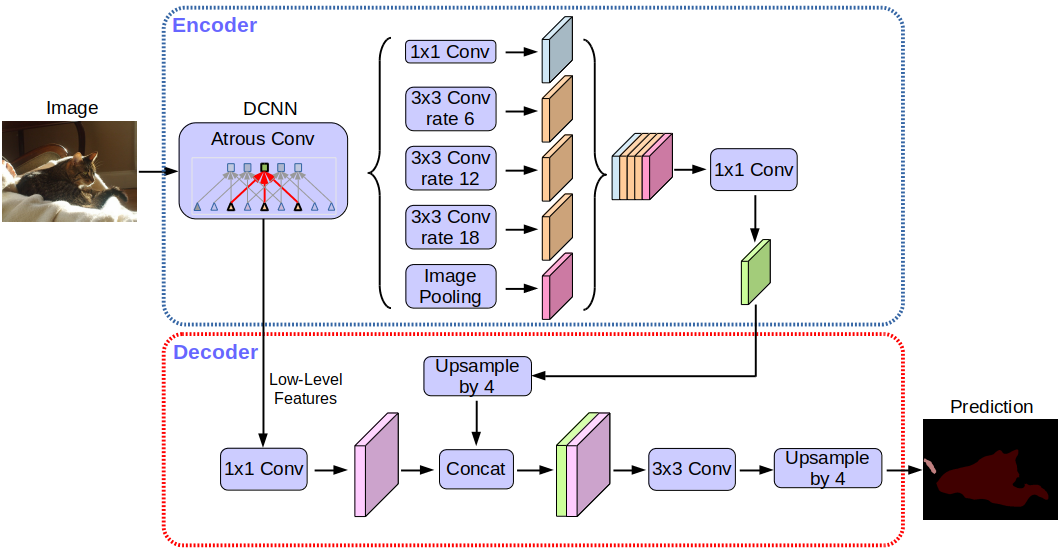

As, same operation of **Convolution, Batch Normalization and ReLU** activation is **repeated again and again**. It will be a **good idea** to represent them as a **single layer**.

In [82]:
class ConvBlock(Layer):
    
    def __init__(self, filters=256, kernel_size=3, dilation_rate=1, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        
        self.net = Sequential([
            Conv2D(filters, kernel_size=kernel_size, padding='same', dilation_rate=dilation_rate, use_bias=False, kernel_initializer='he_normal'),
            BatchNormalization(), 
            ReLU()
        ])
    
    def call(self, X):
        return self.net(X)
    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "kernel_size":self.kernel_size,
            "dilation_rate":self.dilation_rate,
        }

Let's create the **Atrous Spatial Pyramid Pooling layer**.

In [83]:
def AtrousSpatialPyramidPooling(X):
    B, H, W, C = X.shape
    
    # Image Pooling
    image_pool = AveragePooling2D(pool_size=(H, W), name="ASPP-AvgPool")(X)
    image_pool = ConvBlock(kernel_size=1, name="ASPP-ImagePool-CB")(image_pool)
    image_pool = UpSampling2D(size=(H//image_pool.shape[1], W//image_pool.shape[2]), name="ASPP-ImagePool-UpSample")(image_pool)
    
    # Atrous Oprtations
    conv_1  = ConvBlock(kernel_size=1, dilation_rate=1, name="ASPP-CB-1")(X)
    conv_6  = ConvBlock(kernel_size=3, dilation_rate=6, name="ASPP-CB-6")(X)
    conv_12 = ConvBlock(kernel_size=3, dilation_rate=12, name="ASPP-CB-12")(X)
    conv_18 = ConvBlock(kernel_size=3, dilation_rate=18, name="ASPP-CB-18")(X)
    
    # Combine All
    combined = Concatenate(name="ASPP-Combine")([image_pool, conv_1, conv_6, conv_12, conv_18])
    processed = ConvBlock(kernel_size=1, name="ASPP-Net")(combined)
    
    # Final Output
    return processed

It's time to build the final **DeepLabV3+ model**.

In [84]:
# PARAM
LR = 1e-3
IMAGE_SIZE = 128

# Input
InputL = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="InputLayer")

# Base Mode
resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=InputL)

# ASPP Phase
DCNN = resnet50.get_layer('conv4_block6_2_relu').output
ASPP = AtrousSpatialPyramidPooling(DCNN)
ASPP = UpSampling2D(size=(IMAGE_SIZE//4//ASPP.shape[1], IMAGE_SIZE//4//ASPP.shape[2]), name="AtrousSpatial")(ASPP)

# LLF Phase
LLF = resnet50.get_layer('conv2_block3_2_relu').output
LLF = ConvBlock(filters=48, kernel_size=1, name="LLF-ConvBlock")(LLF)

# Combined
combined = Concatenate(axis=-1, name="Combine-LLF-ASPP")([ASPP, LLF])
features = ConvBlock(name="Top-ConvBlock-1")(combined)
features = ConvBlock(name="Top-ConvBlock-2")(features)
upsample = UpSampling2D(size=(IMAGE_SIZE//features.shape[1], IMAGE_SIZE//features.shape[1]), interpolation='bilinear', name="Top-UpSample")(features)

# Output Mask
PredMask = Conv2D(3, kernel_size=3, strides=1, padding='same', activation='sigmoid', use_bias=False, name="OutputMask")(upsample)

# DeelLabV3+ Model
model = Model(InputL, PredMask, name="DeepLabV3-Plus")
model.summary()

Model: "DeepLabV3-Plus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['InputLayer[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

# **Model Visualization**

Because of the use of **ResNet 50** the **model architecture** is **quite big**.

In [85]:
plot_model(model, "DeepLabV3+.png", show_shapes=True, dpi=96)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# **Model Training**

I trust on **my eyes rather then trusting on a metric**. That's why I have created the **Custom Callbacks** this **Custom Callbacks** shows the **Model Predictions** (i.e the **Predicted Label Maps** after every **5th Epcoh**). This allow me to have a look at the **Model's Performance**.

In [86]:
x_train.shape

(800, 128, 128, 3)

In [ ]:
# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


history=model.fit(x_train,
          y_train,
          batch_size=25, 
          epochs=60,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/60
32/32 [==============================] - 930s 28s/step - loss: 0.4042 - val_loss: 559.6701
Epoch 2/60
32/32 [==============================] - 902s 28s/step - loss: 0.3232 - val_loss: 2.6605
Epoch 3/60
22/32 [===================>..........] - ETA: 4:27 - loss: 0.2843

In [ ]:
#plot the training and validation loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#plot the training and validation accuracy at each epoch
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
########## Predicting random images from x_val ######### 
for i in range(0,7):    
    random_num = random.randint(0,500)
    original_image = x_val[random_num]
    imshow(original_image)
    print("Original Image: ")
    plt.show()

    original_image=np.expand_dims(original_image,axis=0)
    predicted_mask = model.predict(original_image)
    predicted_mask = predicted_mask.reshape(mask.shape)
    print("Predicted Mask: ")
    imshow(predicted_mask,cmap='gray')
    plt.show()
    i+=1

In [ ]:
model.save("deeplabv3.hdf5")

I am hoping for **training to get diverged for few iterations** and then **come back to the normal**. Because this is generally what I have seen with **DeeplabV3+**, it happens. And **after diverging**, for **some reason it performs way better than its previous version**. As expected, you can see that the **model training has diverged**.

Epoch 1/20
62/62 [==============================] - 4s 62ms/step - loss: 0.2123 - val_loss: 0.3596
Epoch 2/20
62/62 [==============================] - 4s 61ms/step - loss: 0.2136 - val_loss: 0.4146
Epoch 3/20
62/62 [==============================] - 4s 63ms/step - loss: 0.2038 - val_loss: 0.5960
Epoch 4/20
62/62 [==============================] - 4s 61ms/step - loss: 0.1922 - val_loss: 0.4322
Epoch 5/20
62/62 [==============================] - 4s 61ms/step - loss: 0.1740 - val_loss: 0.3001


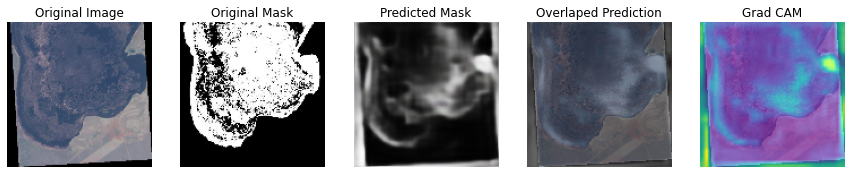

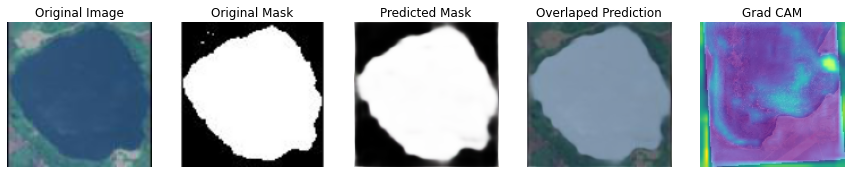

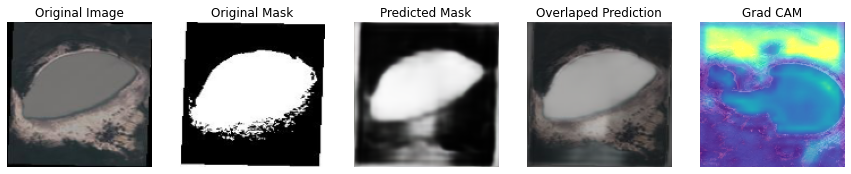

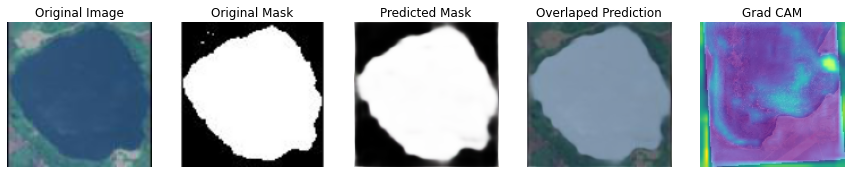

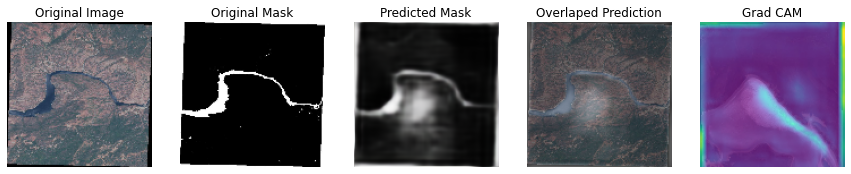

Epoch 6/20
62/62 [==============================] - 4s 61ms/step - loss: 0.1562 - val_loss: 0.2864
Epoch 7/20
62/62 [==============================] - 4s 62ms/step - loss: 0.1458 - val_loss: 0.2656
Epoch 8/20
62/62 [==============================] - 4s 62ms/step - loss: 0.1341 - val_loss: 0.3054
Epoch 9/20
62/62 [==============================] - 4s 60ms/step - loss: 0.1256 - val_loss: 0.2622
Epoch 10/20
62/62 [==============================] - 4s 59ms/step - loss: 0.1205 - val_loss: 0.2861


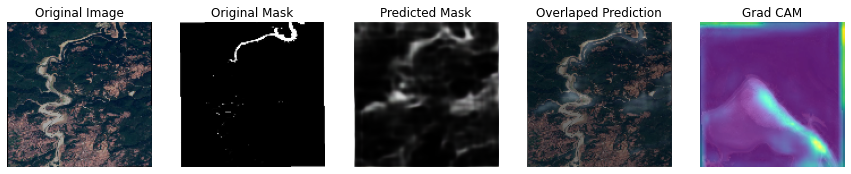

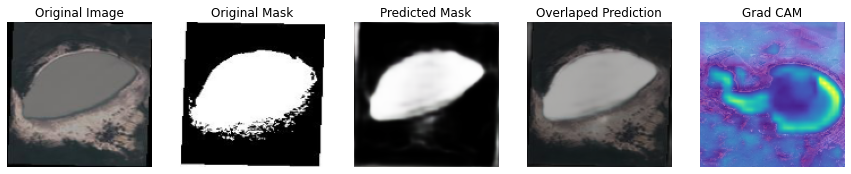

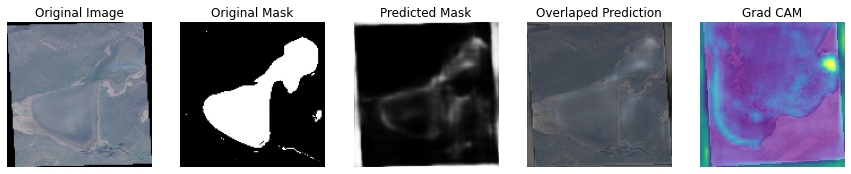

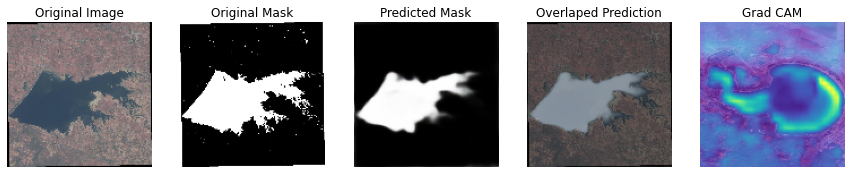

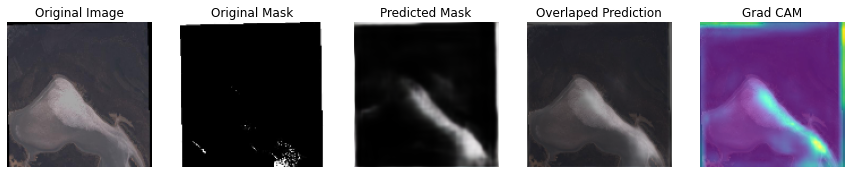

Epoch 11/20
62/62 [==============================] - 4s 60ms/step - loss: 0.1145 - val_loss: 0.2744
Epoch 12/20
62/62 [==============================] - 4s 61ms/step - loss: 0.1161 - val_loss: 0.3016
Epoch 13/20
62/62 [==============================] - 4s 61ms/step - loss: 0.1112 - val_loss: 0.2707
Epoch 14/20
62/62 [==============================] - 4s 60ms/step - loss: 0.1054 - val_loss: 0.3184
Epoch 15/20
62/62 [==============================] - 4s 61ms/step - loss: 0.1023 - val_loss: 0.2892


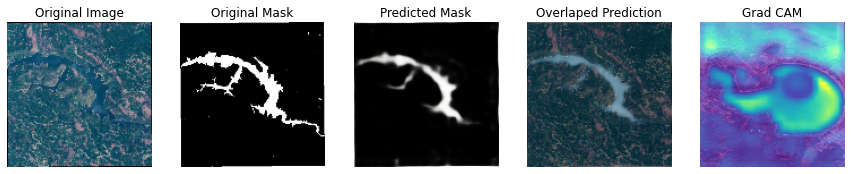

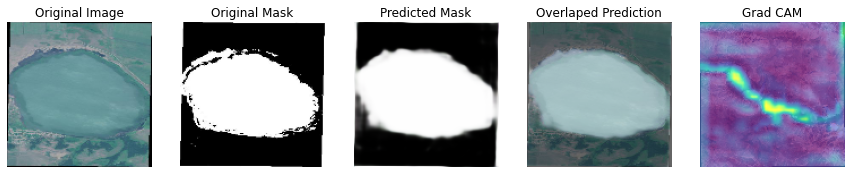

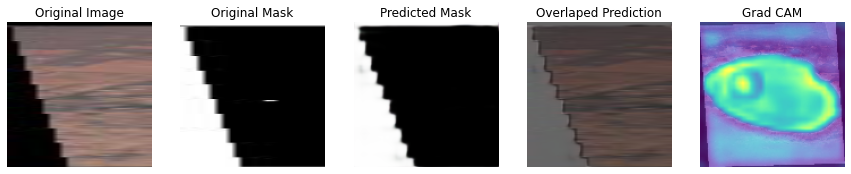

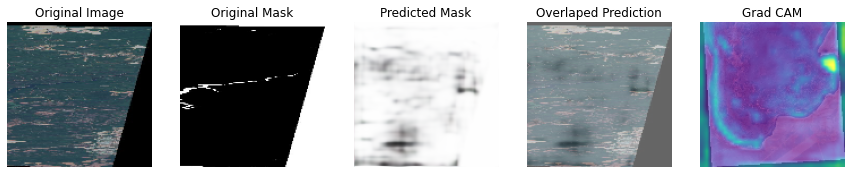

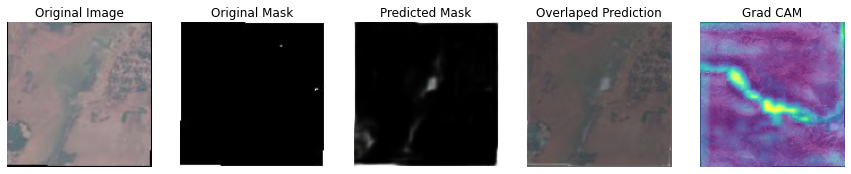

Epoch 16/20
62/62 [==============================] - 4s 60ms/step - loss: 0.0990 - val_loss: 0.3096
Epoch 17/20
62/62 [==============================] - 4s 62ms/step - loss: 0.0953 - val_loss: 0.3262
Epoch 18/20
62/62 [==============================] - 4s 60ms/step - loss: 0.0937 - val_loss: 0.3220
Epoch 19/20
62/62 [==============================] - 4s 61ms/step - loss: 0.0940 - val_loss: 0.3284
Epoch 20/20
62/62 [==============================] - 4s 60ms/step - loss: 0.0933 - val_loss: 0.3383


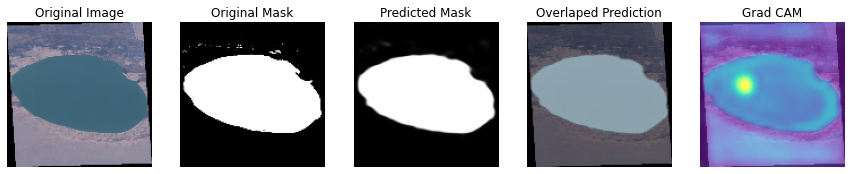

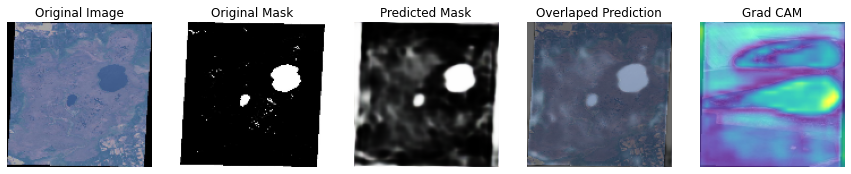

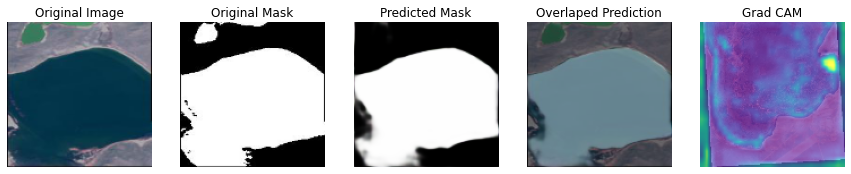

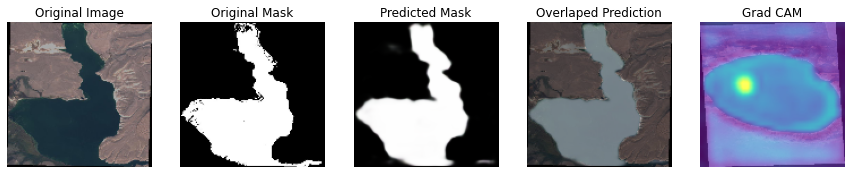

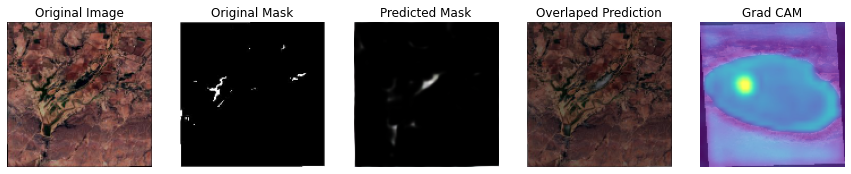

In [19]:
model.fit(train_ds, validation_data=valid_ds, epochs=20, callbacks=callbacks)

# **Model Predictions**

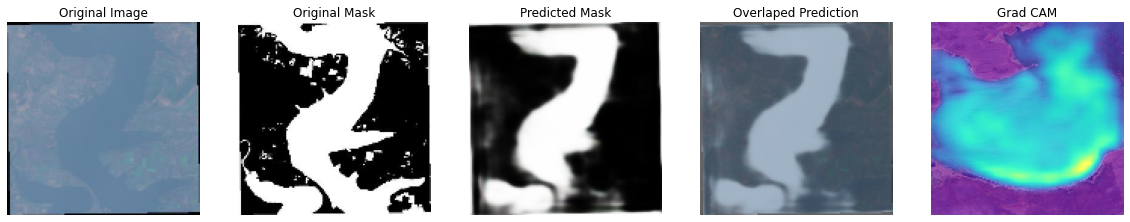

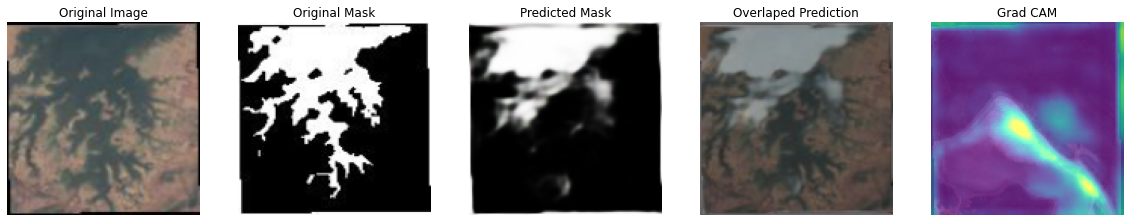

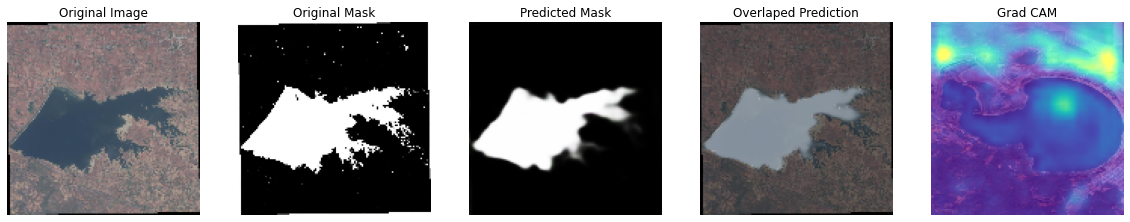

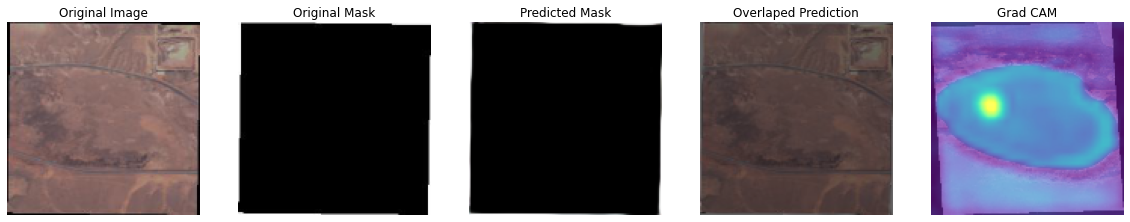

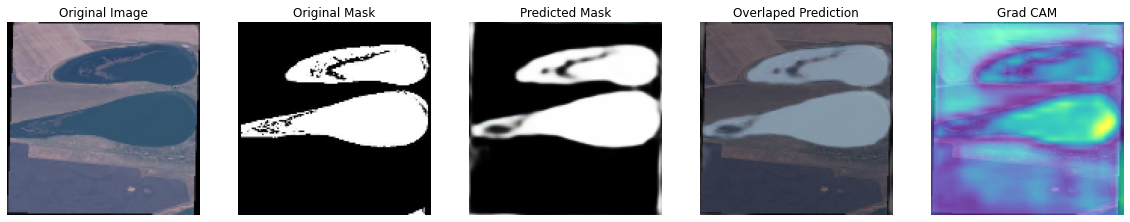

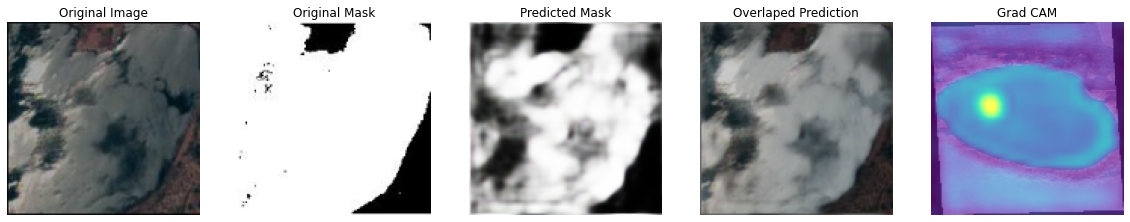

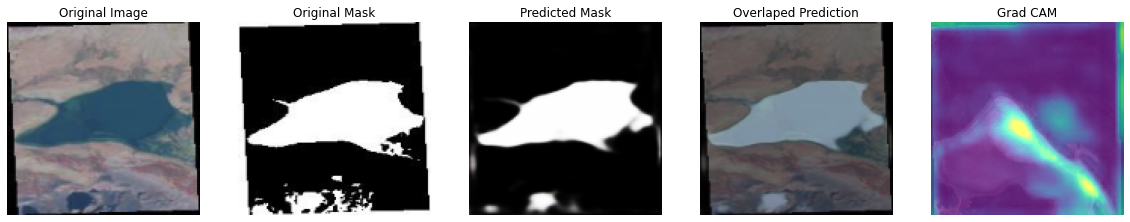

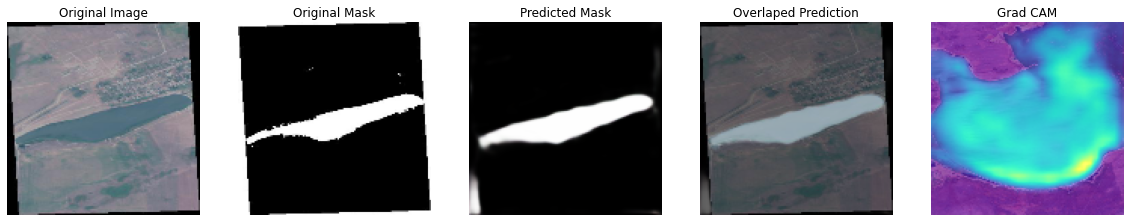

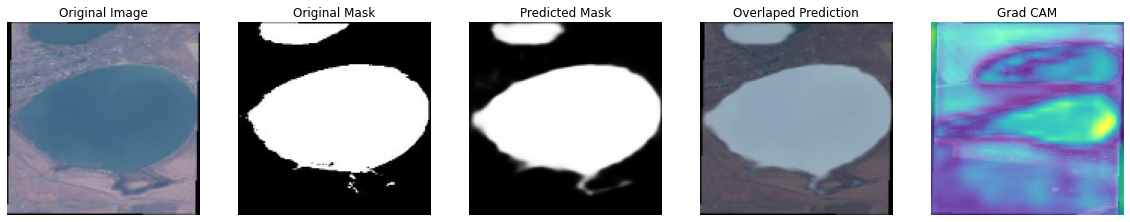

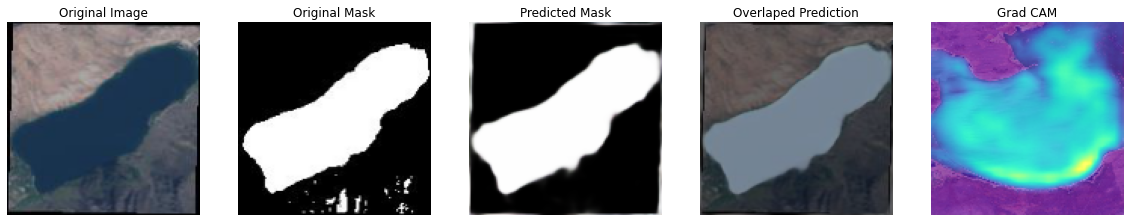

In [20]:
show_images(valid_ds, model=model, explain=True, n_images=10, SIZE=(20,8))

All the **predictions are next to perfect**, although the **model still make blurry maps**. Thats all from my side. Please **let me know your suggestions** in the comments. 

**ThankYou**

---
**DeepNets**